# Spatial Scan Demo Run Through

In [1]:
import pandas as pd
from region import *
from timeseries import *
from scan import *

Would get this from SCOOT query. Contains data from Acton over the month of May.

In [2]:
acton_df = pd.read_csv('ActonMay4.csv')
acton_df = acton_df.drop("Unnamed: 0", axis=1)
acton_df = convert_dates(acton_df)
acton_df

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval
0,N24/012a1,-0.288008,51.481486,2020-05-05 00:00:00,2020-05-05 01:00:00,35
1,N24/012a1,-0.288008,51.481486,2020-05-05 01:00:00,2020-05-05 02:00:00,31
2,N24/012a1,-0.288008,51.481486,2020-05-05 02:00:00,2020-05-05 03:00:00,35
3,N24/012a1,-0.288008,51.481486,2020-05-05 03:00:00,2020-05-05 04:00:00,26
4,N24/012a1,-0.288008,51.481486,2020-05-05 04:00:00,2020-05-05 05:00:00,90
...,...,...,...,...,...,...
132749,N27/299a1,-0.308928,51.512572,2020-06-04 19:00:00,2020-06-04 20:00:00,450
132750,N27/299a1,-0.308928,51.512572,2020-06-04 20:00:00,2020-06-04 21:00:00,329
132751,N27/299a1,-0.308928,51.512572,2020-06-04 21:00:00,2020-06-04 22:00:00,263
132752,N27/299a1,-0.308928,51.512572,2020-06-04 22:00:00,2020-06-04 23:00:00,183


Create forecast df using the past 28 days to predict the next 1.

In [3]:
forecast_df = count_baseline(acton_df, 28, 1, method="HW")
forecast_df

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,baseline,count
0,N24/012a1,-0.288008,51.481486,2020-06-03 23:00:00,2020-06-04 00:00:00,73.854438,NaN
1,N24/012a1,-0.288008,51.481486,2020-06-04 00:00:00,2020-06-04 01:00:00,37.287294,53.0
2,N24/012a1,-0.288008,51.481486,2020-06-04 01:00:00,2020-06-04 02:00:00,31.774988,38.0
3,N24/012a1,-0.288008,51.481486,2020-06-04 02:00:00,2020-06-04 03:00:00,43.542459,34.0
4,N24/012a1,-0.288008,51.481486,2020-06-04 03:00:00,2020-06-04 04:00:00,107.126767,43.0
...,...,...,...,...,...,...,...
4315,N27/299a1,-0.308928,51.512572,2020-06-04 18:00:00,2020-06-04 19:00:00,414.951541,458.0
4316,N27/299a1,-0.308928,51.512572,2020-06-04 19:00:00,2020-06-04 20:00:00,330.917129,450.0
4317,N27/299a1,-0.308928,51.512572,2020-06-04 20:00:00,2020-06-04 21:00:00,288.648683,329.0
4318,N27/299a1,-0.308928,51.512572,2020-06-04 21:00:00,2020-06-04 22:00:00,221.771609,263.0


Let's see what we're looking at

In [4]:
forecast_df = convert_dates(forecast_df)

In [5]:
acton_region = infer_global_region(forecast_df)
print(acton_region)
print("Number of Days: ", acton_region.num_days())

(-0.319886336964428, -0.271241278649333) x (51.4802004523429, 51.516829592048396) x (2020-06-03 23:00:00, 2020-06-04 23:00:00)
Number of Days:  1


Above shows the global region of space-time that we are looking at. (Lon x Lat x Time_interval)

We can find the count of vehicles in this whole region by calling `region_event_count`. This is nor fomratted to count in millions.

In [6]:
baseline, count = region_event_count(acton_region, forecast_df)

In [7]:
print("Baseline Count: {}".format(baseline))
print("Actual Count: {}".format(count))

Baseline Count: 1.2283597584394106
Actual Count: 1.196769


We can plot a time-slice of this global region and its imposed grid, by calling `plot_region_grid`. Good for gauging which grid sizes will work well or not. First, find a random test_date:

In [8]:
test_date = forecast_df['measurement_end_utc'][7]
test_date

Timestamp('2020-06-04 07:00:00')

Here, we choose to divide the region into an 8x8 grid

In [9]:
N = 8

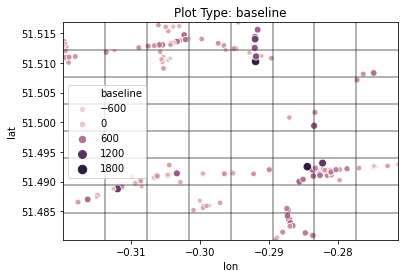

In [10]:
plot_region_grid(forecast_df, test_date, grid_partition=N, plot_type='baseline')

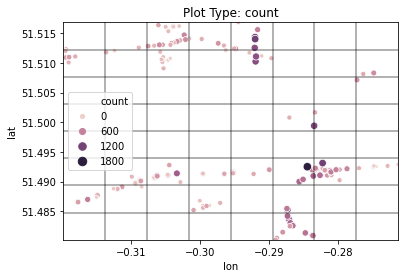

In [11]:
plot_region_grid(forecast_df, test_date, grid_partition=N, plot_type='count')

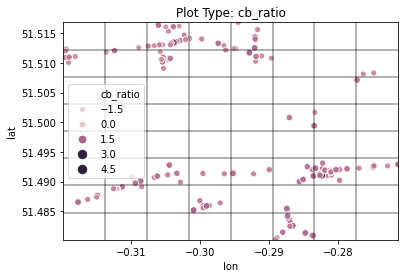

In [12]:
plot_region_grid(forecast_df, test_date, grid_partition=N, plot_type='cb_ratio')

### The Main Scan

EBP will perform the main scan, and return a dataframe listing all searched space-time regions and their associated score. All we need to specify is the forecast dataframe (which implicitly encodes the length of the time window), and the number of partitions per spatial axis $N$.

In [13]:
# For convenience, instead of running the `res_df = EBP()` cell,
# the dataframe can be loaded here.

res_df = pd.read_csv("res.csv")
res_df["t_min"] = pd.to_datetime(res_df["t_min"])
res_df["t_max"] = pd.to_datetime(res_df["t_max"])

In [14]:
#res_df = EBP(forecast_df, N)

Here, we return dataframe, giving information on the 31104 regions of space-time that have been tested.

In [15]:
res_df

,x_min,x_max,y_min,y_max,t_min,t_max,likelihood_score,p_value
0,-0.295564,-0.283403,51.507672,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996,NaN
1,-0.295564,-0.289483,51.507672,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996,NaN
2,-0.295564,-0.277322,51.507672,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996,NaN
3,-0.295564,-0.289483,51.498515,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996,NaN
4,-0.295564,-0.283403,51.503094,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996,NaN
...,...,...,...,...,...,...,...,...
31099,-0.277322,-0.271241,51.512251,51.516830,2020-06-03 23:00:00,2020-06-04 19:00:00,NaN,NaN
31100,-0.277322,-0.271241,51.512251,51.516830,2020-06-03 23:00:00,2020-06-04 20:00:00,NaN,NaN
31101,-0.277322,-0.271241,51.512251,51.516830,2020-06-03 23:00:00,2020-06-04 21:00:00,NaN,NaN
31102,-0.277322,-0.271241,51.512251,51.516830,2020-06-03 23:00:00,2020-06-04 22:00:00,NaN,NaN


Later, we will introduce 'Randomisation Testing' which will allow us to quantifify how significant these clusters are. This will populate the `p_value` column. For now, we can afford to drop it.

In [16]:
res_df = res_df.drop("p_value", axis=1).dropna()
res_df

,x_min,x_max,y_min,y_max,t_min,t_max,likelihood_score
0,-0.295564,-0.283403,51.507672,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996
1,-0.295564,-0.289483,51.507672,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996
2,-0.295564,-0.277322,51.507672,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996
3,-0.295564,-0.289483,51.498515,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996
4,-0.295564,-0.283403,51.503094,51.512251,2020-06-03 23:00:00,2020-06-04 03:00:00,1.001996
...,...,...,...,...,...,...,...
26875,-0.313806,-0.283403,51.489358,51.498515,2020-06-03 23:00:00,2020-06-04 15:00:00,1.000000
26876,-0.313806,-0.283403,51.489358,51.498515,2020-06-03 23:00:00,2020-06-04 14:00:00,1.000000
26877,-0.313806,-0.283403,51.489358,51.498515,2020-06-03 23:00:00,2020-06-04 13:00:00,1.000000
26878,-0.313806,-0.283403,51.489358,51.498515,2020-06-03 23:00:00,2020-06-04 12:00:00,1.000000


We see that the region with the highest emerging-cluster score is partiularly near 3am in the morning of the 4th of June. Let's see how this contributes overall.

In [17]:
test_date = res_df['t_max'].iloc[0]
test_date
isinstance(test_date, datetime)

True

In [79]:
def plot_results(res_df, time_slice, grid_partition):
    res_df = res_df[res_df['t_max'] == time_slice]
  
    x_min = res_df["x_min"].min()
    x_max = res_df["x_max"].max()
    y_min = res_df["y_min"].min()
    y_max = res_df["y_max"].max()
        
    x_ticks = np.linspace(x_min, x_max, grid_partition + 1)
    y_ticks = np.linspace(y_min, y_max, grid_partition + 1)
    
    x_labels = ["{0:.3f}".format((x_ticks[i] + x_ticks[i+1])/2) for i in range(len(x_ticks) - 1)]
    y_labels = ["{0:.3f}".format((y_ticks[i] + y_ticks[i+1])/2) for i in reversed(range(len(y_ticks) - 1))]
    
    region_scores = []
    for j in range(len(y_ticks) - 1):
        region_col_scores = []
        for i in range(len(x_ticks) - 1):
        
            sub_df = res_df[(res_df["x_min"] <= x_ticks[i]) &
                            (res_df["x_max"] >= x_ticks[i + 1]) & 
                            (res_df["y_min"] <= y_ticks[j])&
                            (res_df["y_max"] >= y_ticks[j + 1])
                           ]
            region_score = sub_df["likelihood_score"].sum() / len(sub_df["likelihood_score"])
            region_col_scores.append(region_score)
        region_scores.insert(0, region_col_scores)
        
    sbn.heatmap(region_scores, xticklabels=x_labels, yticklabels=y_labels, fmt=".5f", cbar=True, vmin=1, vmax=1.0005)
    plt.xlabel("Lon")
    plt.ylabel("Lat")
    plt.title("Spatial Scan of Grid Size {} x {} at {}".format(grid_partition, grid_partition, time_slice))
    return None
 

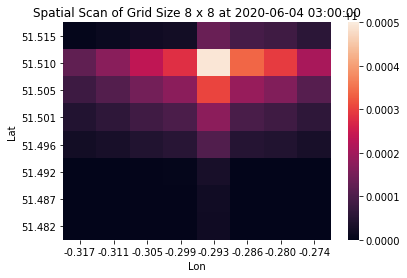

In [80]:
plot_results(res_df, test_date, N)

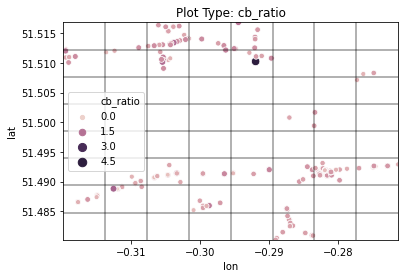

In [20]:
plot_region_grid(forecast_df, test_date, N, plot_type='cb_ratio')

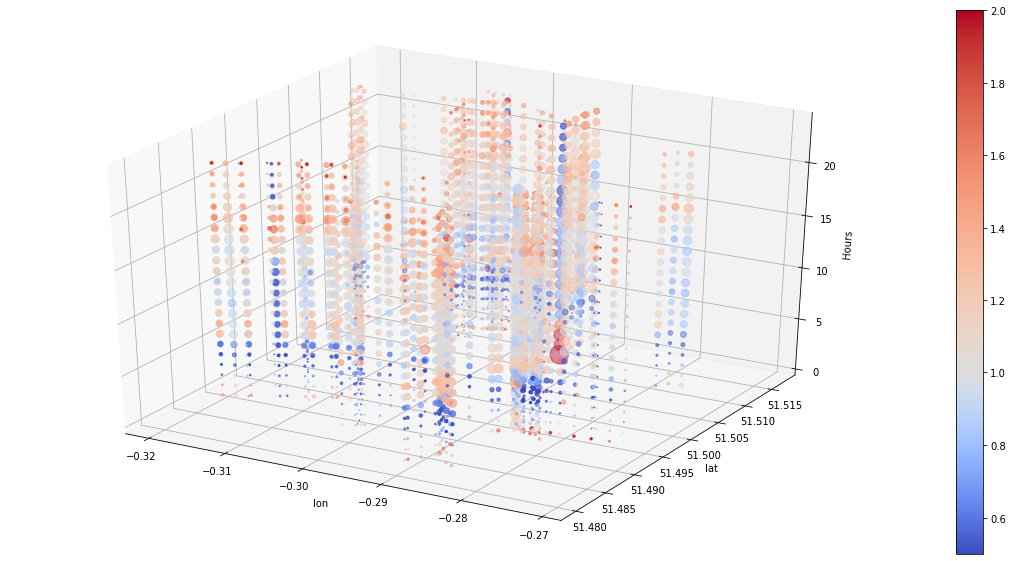

In [21]:
CB_plot(forecast_df)

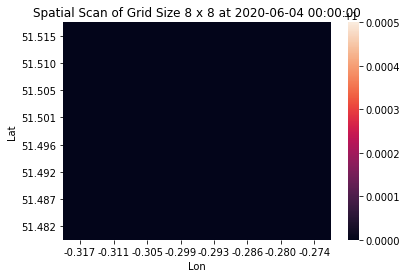

In [104]:
plot_results(res_df, test_date - np.timedelta64(3,'h'), N)

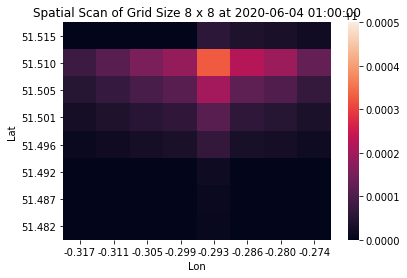

In [105]:
plot_results(res_df, test_date - np.timedelta64(2,'h'), N)

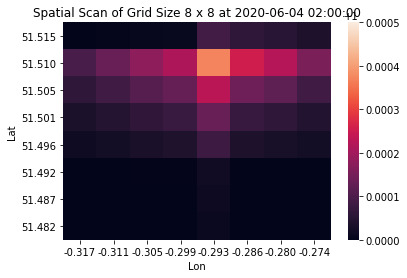

In [106]:
plot_results(res_df, test_date - np.timedelta64(1,'h'), N)

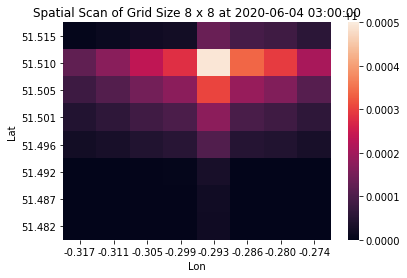

In [107]:
plot_results(res_df, test_date - np.timedelta64(0,'h'), N)

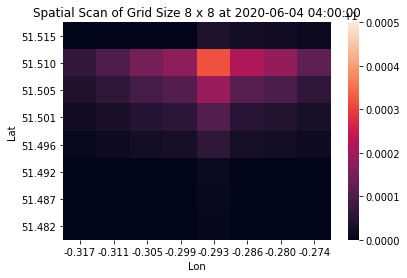

In [108]:
plot_results(res_df, test_date + np.timedelta64(1,'h'), N)

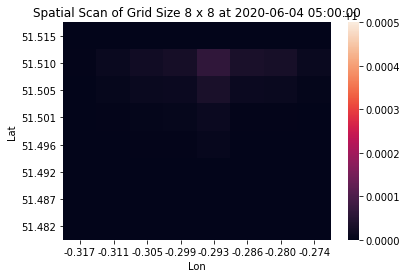

In [109]:
plot_results(res_df, test_date + np.timedelta64(2,'h'), N)

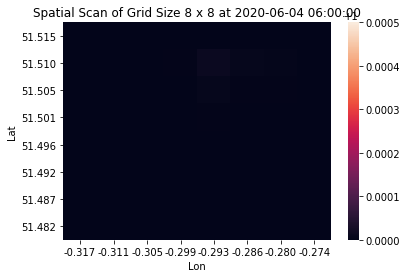

In [110]:
plot_results(res_df, test_date + np.timedelta64(3,'h'), N)

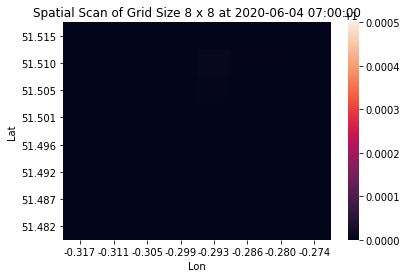

In [111]:
plot_results(res_df, test_date + np.timedelta64(4,'h'), N)

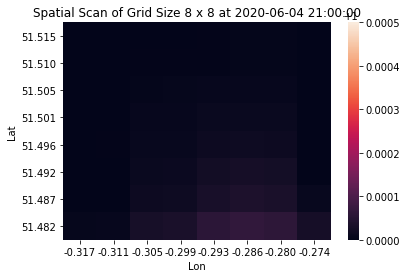

In [113]:
plot_results(res_df, test_date + np.timedelta64(18,'h'), N)

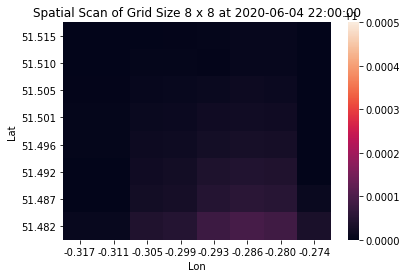

In [115]:
plot_results(res_df, test_date + np.timedelta64(19,'h'), N)

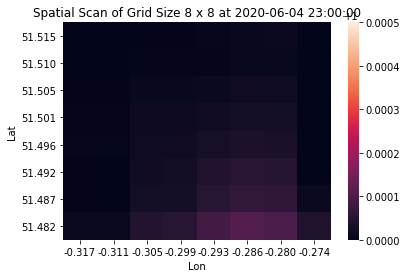

In [117]:
plot_results(res_df, test_date + np.timedelta64(20,'h'), N)